In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

from torch.utils.data import DataLoader
from helpers.utils import get_car_filenames, show_img_mask
from helpers.datasets import CarDataset

# 1. Dataset

In [3]:
transforms = [
    A.Resize(1024, 1024),
    A.Rotate(),
    A.Flip(),
    A.ColorJitter()
]

train_dataset = CarDataset(*get_car_filenames(), dataset_expand_ratio=3, transforms=transforms)
test_dataset = CarDataset(*get_car_filenames(mode="test"))
print(f"#training samples: {len(train_dataset)}, #test samples: {len(test_dataset)}")

#training samples: 288, #test samples: 3


index: 61
torch.Size([3, 1024, 1024]), torch.Size([1024, 1024])


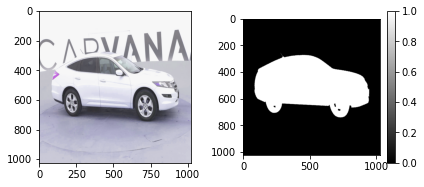

In [7]:
# visualize the dataset
index = np.random.randint(0, len(train_dataset))
print(f"index: {index}")
img, mask = train_dataset[index]
print(f"{img.shape}, {mask.shape}")
show_img_mask(img=img.permute(1, 2, 0).numpy(), mask=mask.numpy())

In [8]:
train_loader_args = dict(batch_size=8, shuffle=True, num_workers=0)
test_loader_args = dict(batch_size=1, num_workers=0)
train_loader = DataLoader(train_dataset, **train_loader_args)
test_loader = DataLoader(test_dataset, **test_loader_args)

In [9]:
for imgs, masks in train_loader:
    print(f"{imgs.shape}, {masks.shape}")
    break

torch.Size([8, 3, 1024, 1024]), torch.Size([8, 1024, 1024])
